# Optimizing SMACross Trading with MultiModal Agent

In the `agent_trade_strategist` demo. We explored an agent that could write trading strategy. But optimizing the strategy can be a hard problem, as the analysis it could do is really limited. Thus it would be crucial for us to turn on its vision swicth !

In this demo, we introduce a multimodal agent to leverage the current strategy, and adjust parameters accordingly.

In [1]:
import autogen
from autogen import AssistantAgent, UserProxyAgent
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.cache import Cache
from textwrap import dedent

In [2]:
config_list_4v = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-1106-vision-preview"],
    },
)
config_list = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-0125-preview"],
    },
)
llm_config_4v = {"config_list": config_list_4v, "temperature": 0.0}
llm_config = {"config_list": config_list, "temperature": 0.0}

For this task, we need:
- A normal llm agent as image provider: Call charting functions / provide backtesting result charts for multimodal agent
- A multimodal agent as strategist: Inspect charts and determine parameters to use for strategy
- A user proxy to execute python functions and control the conversations.

In [3]:
from finrobot.toolkits import register_toolkits
from finrobot.functional.charting import MplFinanceUtils
from finrobot.functional.quantitative import BackTraderUtils
from finrobot.functional.coding import IPythonUtils


strategist = MultimodalConversableAgent(
    name="Trade_Strategist",
    system_message=dedent(
        """
        You are a trading strategist who inspect financial charts and optimize trading strategies.
        You have been tasked with developing a Simple Moving Average (SMA) Crossover strategy.
        You have the following main actions to take:
        1. Ask the backtesting analyst to plot historical stock price data with designated ma parameters.
        2. Inspect the stock price chart and determine fast/slow parameters.
        3. Ask the backtesting analyst to backtest the SMACrossover trading strategy with designated parameters to evaluate its performance. 
        4. Inspect the backtest result and optimize the fast/slow parameters based on the returned results.
        Reply TERMINATE when you think the strategy is good enough.
        """
    ),
    llm_config=llm_config_4v,
)

analyst = AssistantAgent(
    name="Backtesting_Analyst",
    system_message=dedent(
        """
        You are a backtesting analyst with a strong command of quantitative analysis tools. 
        You have two main tasks to perform, choose one each time you are asked by the trading strategist:
        1. Plot historical stock price data with designated ma parameters according to the trading strategist's need.
        2. Backtest the SMACross trading strategy with designated parameters and save the results as image file.
        For both tasks, after the tool calling, you should do as follows:
            1. display the created & saved image file using the `display_image` tool;
            2. Assume the saved image file is "test.png", reply as follows: "Optimize the fast/slow parameters based on this image <img test.png>. TERMINATE".
        """
    ),
    llm_config=llm_config,
)
analyst_executor = UserProxyAgent(
    name="Backtesting_Analyst_Executor",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "coding",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)
register_toolkits(
    [
        BackTraderUtils.back_test,
        MplFinanceUtils.plot_stock_price_chart,
        IPythonUtils.display_image,
    ],
    analyst,
    analyst_executor,
)

In [8]:
def reflection_message_analyst(recipient, messages, sender, config):
    print("Reflecting strategist's response ...")
    last_msg = recipient.chat_messages_for_summary(sender)[-1]["content"]
    return (
        "Message from Trade Strategist is as follows:"
        + last_msg
        + "\n\nBased on his information, conduct a backtest on the specified stock and strategy, and report your backtesting results back to the strategist."
    )


user_proxy = UserProxyAgent(
    name="User_Proxy",
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "coding",
        "use_docker": False,
    },  # User Proxy dont need to execute code here
)

user_proxy.register_nested_chats(
    [
        {
            "sender": analyst_executor,
            "recipient": analyst,
            "message": reflection_message_analyst,
            "max_turns": 10,
            "summary_method": "last_msg",
        }
    ],
    trigger=strategist,
)

User_Proxy (to Trade_Strategist):


Based on Microsoft's stock data from 2022-01-01 to 2024-01-01, determine the possible optimal parameters for an SMACrossover Strategy over this period. 
First, ask the analyst to plot a candlestick chart of the stock price data to visually inspect the price movements and make an initial assessment.
Then, ask the analyst to backtest the strategy parameters using the backtesting tool, and report results back for further optimization.


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategist (to User_Proxy):

Certainly, let's start by getting a visual on the stock price movements.

1. Please plot a candlestick chart of Microsoft's stock price data from 2022-01-01 to 2024-01-01. Include a 50-day and a 200-day Simple Moving Average on the chart for initial assessment.

--------------------------------------------------------------------------------
Reflecting strategist's response ...

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_CgHll9hsFHau3D7dGfFSyV26) *****
candle chart saved to <img microsoft_stock_price_chart.png>
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Analyst (to Backtesting_Analyst_Executor):

***** Suggested tool call (call_8KZ8d4jhghI3onwwGktEirtw): display_image *****
Arguments: 
{"image_path":"microsoft_stock_price_chart.png"}
******************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image...


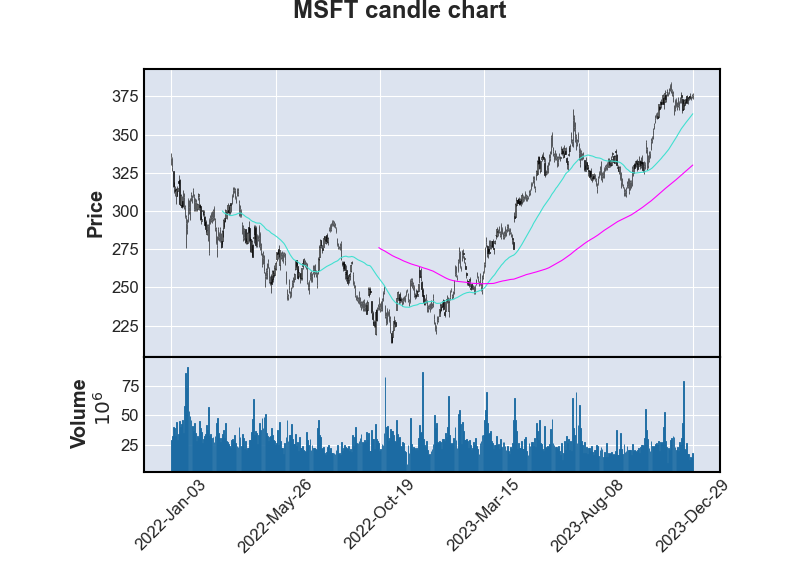

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_8KZ8d4jhghI3onwwGktEirtw) *****
None
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Analyst (to Backtesting_Analyst_Executor):

Optimize the fast/slow parameters based on this image <img microsoft_stock_price_chart.png>. TERMINATE

--------------------------------------------------------------------------------
########## Optimize the fast/slow parameters based on this image <img microsoft_stock_price_chart.png>. TERMINATE
User_Proxy (to Trade_Strategist):

Optimize the fast/slow parameters based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategist (to User_Proxy):

Based on the provided candlestick chart of Microsoft's sto

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_7Pe1hFOeLhmLJTOHRSWGCgIb) *****
Back Test Finished. Results: 
{ 'Drawdown': AutoOrderedDict([ ('len', 96),
                                ('drawdown', 0.4792571591478),
                                ('moneydown', 47.937370222436584),
                                ( 'max',
                                  AutoOrderedDict([ ('len', 96),
                                                    ( 'drawdown',
                                                      0.4792571591478),
                                                    ( 'moneydown',
                                                      47.937370222436584)]))]),
  'Final Portfolio Value': 9954.494373870299,
  'Returns': OrderedDict([ ('rtot', -0.004560947941051167),
                           ('ravg', -6.0329999220253526e-06),
                           ('rnorm', -0.0015191608854

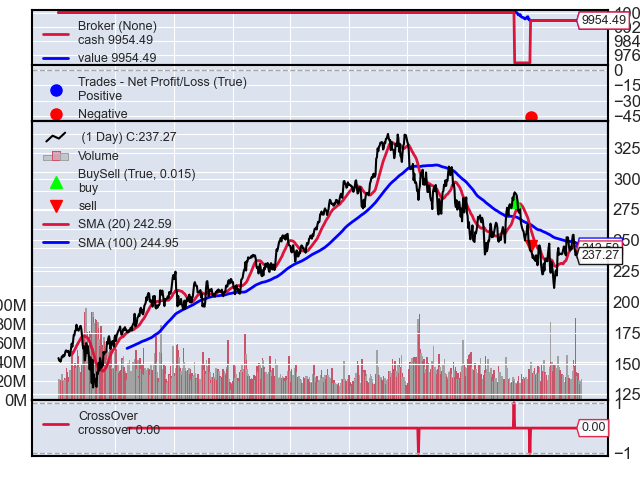

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_FLaewawI4iUAhMihye4hl47y) *****
None
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Analyst (to Backtesting_Analyst_Executor):

Optimize the fast/slow parameters based on this image <img test.png>. TERMINATE

--------------------------------------------------------------------------------
########## Optimize the fast/slow parameters based on this image <img test.png>. TERMINATE
User_Proxy (to Trade_Strategist):

Optimize the fast/slow parameters based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategist (to User_Proxy):

The backtest result image shows the performance of a trading strategy using a 20-day SMA as the fast mov

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_xogelWhCJtGc3qgVyjLKdn5t) *****
Back Test Finished. Results: 
{ 'Drawdown': AutoOrderedDict([ ('len', 250),
                                ('drawdown', 0.6058542319399929),
                                ('moneydown', 61.05225758054621),
                                ( 'max',
                                  AutoOrderedDict([ ('len', 250),
                                                    ( 'drawdown',
                                                      0.6059527628926776),
                                                    ( 'moneydown',
                                                      61.06218659776823)]))]),
  'Final Portfolio Value': 10016.001654389678,
  'Returns': OrderedDict([ ('rtot', 0.0015988865383717893),
                           ('ravg', 2.114929283560568e-06),
                           ('rnorm', 0.000533104

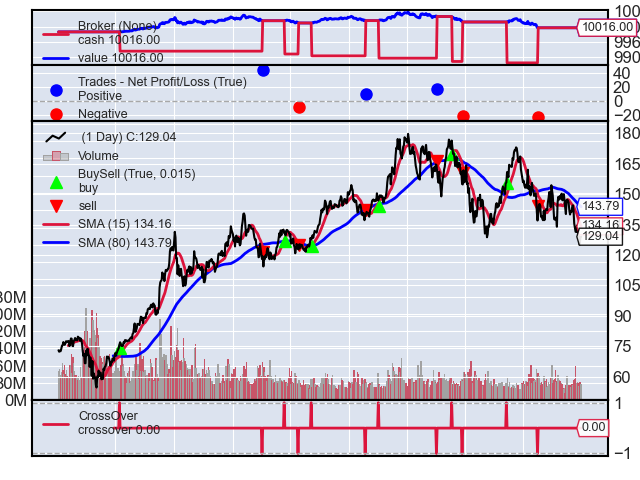

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_BGrbFbvat6Vi5X4XNyp5Yb1p) *****
None
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Analyst (to Backtesting_Analyst_Executor):

Optimize the fast/slow parameters based on this image <img test.png>. TERMINATE

--------------------------------------------------------------------------------
########## Optimize the fast/slow parameters based on this image <img test.png>. TERMINATE
User_Proxy (to Trade_Strategist):

Optimize the fast/slow parameters based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategist (to User_Proxy):

The new backtest result image shows the performance of the trading strategy with a 15-day SMA as the fas

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_CmOF8aT5DDj7M7qpeNv1JEBZ) *****
Back Test Finished. Results: 
{ 'Drawdown': AutoOrderedDict([ ('len', 94),
                                ('drawdown', 0.20209201531982846),
                                ('moneydown', 20.226220805318007),
                                ( 'max',
                                  AutoOrderedDict([ ('len', 94),
                                                    ( 'drawdown',
                                                      0.2195571239014045),
                                                    ( 'moneydown',
                                                      21.974202495741338)]))]),
  'Final Portfolio Value': 9988.195325839277,
  'Returns': OrderedDict([ ('rtot', -0.001181164716546909),
                           ('ravg', -4.705835524091271e-06),
                           ('rnorm', -0.0011851

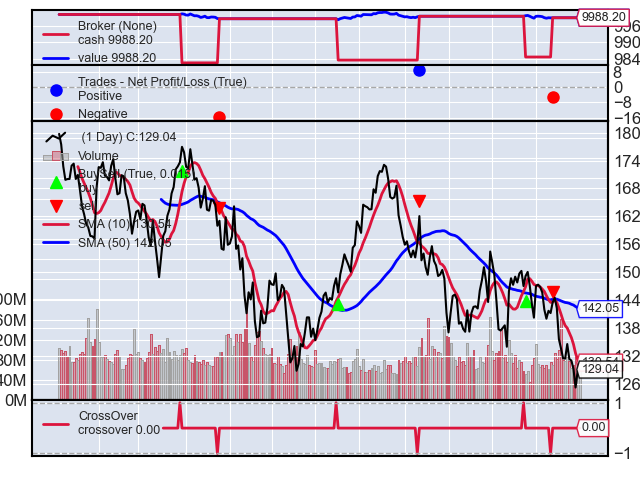

Backtesting_Analyst_Executor (to Backtesting_Analyst):

Backtesting_Analyst_Executor (to Backtesting_Analyst):

***** Response from calling tool (call_Zjl3zZKJcSS9KnyQkk5TSOpf) *****
None
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Analyst (to Backtesting_Analyst_Executor):

Optimize the fast/slow parameters based on this image <img test.png>. TERMINATE

--------------------------------------------------------------------------------
########## Optimize the fast/slow parameters based on this image <img test.png>. TERMINATE
User_Proxy (to Trade_Strategist):

Optimize the fast/slow parameters based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategist (to User_Proxy):

The latest backtest result image shows the performance of the trading strategy with a 10-day SMA as the 

In [12]:
company = "Microsoft"
start_date = "2022-01-01"
end_date = "2024-01-01"

task = dedent(
    f"""
    Based on {company}'s stock data from {start_date} to {end_date}, determine the possible optimal parameters for an SMACrossover Strategy over this period. 
    First, ask the analyst to plot a candlestick chart of the stock price data to visually inspect the price movements and make an initial assessment.
    Then, ask the analyst to backtest the strategy parameters using the backtesting tool, and report results back for further optimization.
"""
)

with Cache.disk() as cache:
    user_proxy.initiate_chat(
        recipient=strategist, message=task, max_turns=5, summary_method="last_msg"
    )